In [ ]:
# ###################################
# Group ID: 222
# Members: Adrián Gómez Repollés, Kresten Johansen, Misbah Unnisa, Mohammadali Zakeriharandi
# Date: 21/03/2024
# Lecture: 8 Multilayer perceptrons
# Dependencies: Numpy, Scipy, Scikit-Learn, Pytorch and Matplotlib.
# Python version: 3.12.2
# Functionality: Jupyter notebook to train an MLP model on MNIST dataset using Scikit-Learn
# ###################################

## Day4 - Exercises

### Develop an MLP for the MNIST database by using the LDA generated 9-dimensional data from your work on DAY 3. You can download the LDA projected data "mnist_lda.mat" under the folder "Data and code" above. Also in ASCII format "mnist_lda_ASCII.zip". Experiment on various MLP architectures and learning rates. (Functions for MLP in the NETLAB toolbox include mlp.m, mlptrain.m and mlpfwd.m.)

In [107]:
## Imports
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

In [23]:
## Load data
def load_data(downsample_train = None):
    # Data
    mnist = sio.loadmat('Data/mnist_all.mat')

    # Train
    trains = [mnist[i].astype(np.float32) / 255 for i in mnist.keys() if "train" in i]
    if downsample_train == None:
        X_train = np.concatenate(trains, axis=0)
        y_train = [np.repeat(i, trains[i].shape[0]) for i in range(10)]
    else:
        subset_trains = []
        for array in trains:
            length = array.shape[0]
            size = int(np.round(length * downsample_train))
            idx = np.random.randint(array.shape[0], size=size)
            subset_trains.append(array[idx,:])
        X_train = np.concatenate(subset_trains, axis=0)
        y_train = [np.repeat(i, subset_trains[i].shape[0]) for i in range(10)]
        y_train = np.concatenate(y_train)

    # Test
    tests = [mnist[i].astype(np.float32) / 255 for i in mnist.keys() if "test" in i]
    X_test = np.concatenate(tests, axis=0)
    y_test = [np.repeat(i, tests[i].shape[0]) for i in range(10)]
    y_test = np.concatenate(y_test)

    # Return
    return(X_train, y_train, X_test, y_test)

My computer would struggle with such a large set of training images. Therefore, I am going to subset the training to a 10% of the total size, and I will keeping the proportions between the different labels. The test set would be kept as it is.

In [25]:
# Downsample Train-Test split data
X_train, y_train, X_test, y_test = load_data(downsample_train=0.10) # 10% of data

**LDA**

In [26]:
# Dimension: 9
lda9 = LinearDiscriminantAnalysis(solver="svd", n_components=9)
lda9 = lda9.fit(X_train, y_train)
lda9_train = lda9.transform(X_train)
lda9_test = lda9.transform(X_test)

**MLP**

I wrote 3 helper functions that would allow me to explore: i) the neural network structure, ii) the training and loss scores and iii) the confusion matrix and accuracy of the model.

In [126]:
## Helper functions

# Describe mlp structure
def mlp_structure(mlp):
    print(f"Number of inputs:  {mlp.n_features_in_}")
    print(f"Number of outputs: {mlp.n_outputs_}")
    print(f"Number of layers:  {mlp.n_layers_}")
    print(f"Layer sizes: {[l.shape for l in mlp.coefs_]}")
    print(f"Solver: {mlp.solver}")
    print(f"Output Activation: {mlp.out_activation_}")

# Plot train-test error
def plot_train_test_error(mlp):
    epochs = np.arange(1, mlp.n_iter_+1,1)
    plt.figure(figsize=(4,3))
    plt.plot(epochs, mlp.validation_scores_, c="orange", label="Training")
    plt.plot(epochs ,mlp.loss_curve_, c="blue", label="Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Score")
    plt.title("Training scores")
    plt.legend()
    plt.show()

# Plot confusion matrices
def plot_confusion_matrix(orig_train, pred_train, orig_test, pred_test, labels):
    # Measure accuracies
    acc_train = accuracy_score(orig_train, pred_train)
    acc_test = accuracy_score(orig_test, pred_test)
    # Create confusion matrices
    cm_train = np.round(confusion_matrix(orig_train, pred_train, labels=labels, normalize='true'),2)
    vcm_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=labels)
    cm_test = np.round(confusion_matrix(orig_test, pred_test, labels=labels, normalize='true'),2)
    vcm_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=labels)
    # Plot confusion matrix
    fig, ax = plt.subplots(1,2, figsize=(8,8))
    plt.rcParams.update({'font.size': 8})
    # Confusion matrices
    vcm_train.plot(ax=ax[0], cmap="Blues", colorbar=None) # Train
    vcm_test.plot(ax=ax[1], cmap="Greens", colorbar=None) # Test
    ax[0].set_title(f"Train (Acc: {np.round(acc_train,2)})") # Train
    ax[1].set_title(f"Test (Acc: {np.round(acc_test,2)})") # Test
    plt.show()

**First model:** default version of the MLP classifier in Scikit Learn but including early stopping. It implements one hidden layer with 100 nodes, the input is 9 dimensions (LDA) and the output is 10 classes (0-9 numbers).

Number of inputs:  9
Number of outputs: 10
Number of layers:  3
Layer sizes: [(9, 100), (100, 10)]
Solver: adam
Output Activation: softmax


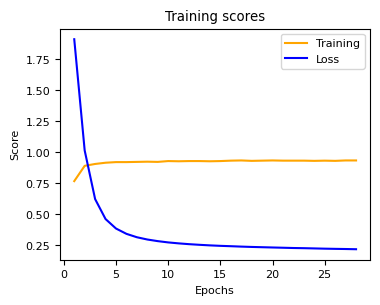

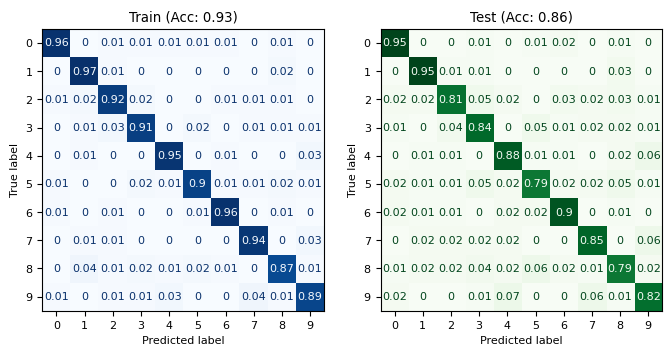

In [127]:
# MLP: Default
mlp = MLPClassifier(random_state=42, max_iter=200, solver="adam", early_stopping=True).fit(lda9_train, y_train)
mlp.fit(lda9_train, y_train)
pred_train = mlp.predict(lda9_train)
pred_test = mlp.predict(lda9_test)
mlp_structure(mlp)
plot_train_test_error(mlp)
plot_confusion_matrix(y_train, pred_train, y_test, pred_test, labels=mlp.classes_)

**Second model:**  MLP classifier, with early stopping, where I choose to use two hidden layer with 256 and 128 nodes, respectively. As before, the input is 9 dimensions (LDA) and the output is 10 classes (0-9 numbers).

Number of inputs:  9
Number of outputs: 10
Number of layers:  4
Layer sizes: [(9, 256), (256, 128), (128, 10)]
Solver: adam
Output Activation: softmax


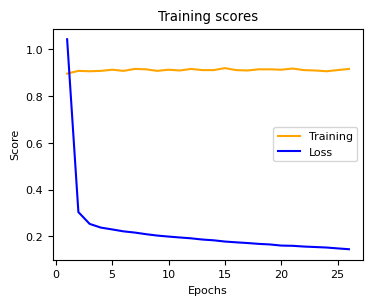

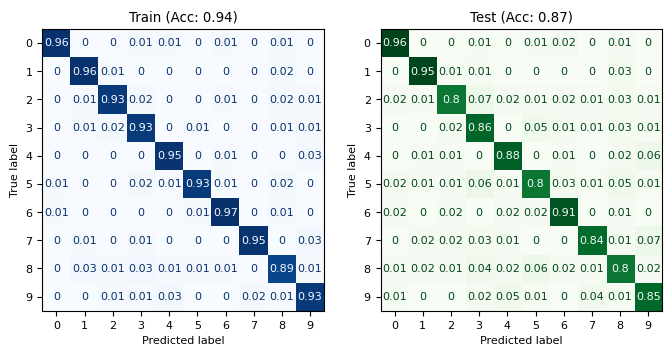

In [128]:
# MLP: 2 big layers in descending order
layers = (256,128)
mlp = MLPClassifier(hidden_layer_sizes=layers, random_state=98, max_iter=200, solver="adam", early_stopping=True).fit(lda9_train, y_train)
mlp.fit(lda9_train, y_train)
pred_train = mlp.predict(lda9_train)
pred_test = mlp.predict(lda9_test)
mlp_structure(mlp)
plot_train_test_error(mlp)
plot_confusion_matrix(y_train, pred_train, y_test, pred_test, labels=mlp.classes_)

**Third model:**  MLP classifier, with early stopping, where I choose to use three hidden layer with 10, 6 and 4 nodes, respectively. As before, the input is 9 dimensions (LDA) and the output is 10 classes (0-9 numbers).

Number of inputs:  9
Number of outputs: 10
Number of layers:  5
Layer sizes: [(9, 10), (10, 6), (6, 4), (4, 10)]
Solver: adam
Output Activation: softmax


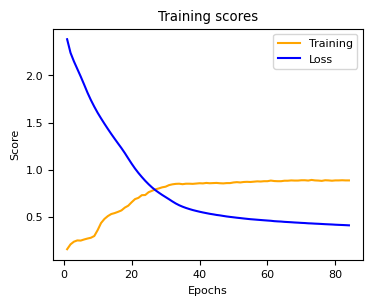

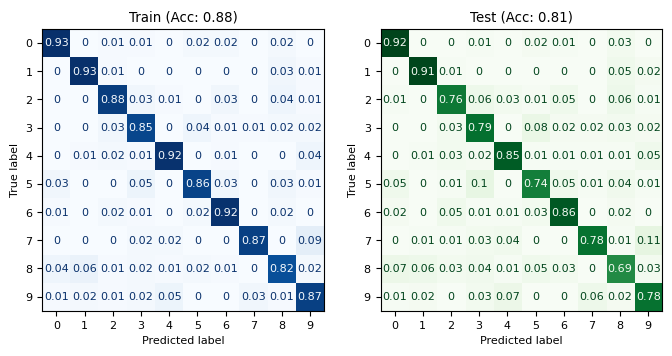

In [129]:
# MLP: 3 layers of decreasing size with few nodes
layers = (10,6,4)
mlp = MLPClassifier(hidden_layer_sizes=layers, random_state=12, max_iter=200, solver="adam", early_stopping=True).fit(lda9_train, y_train)
mlp.fit(lda9_train, y_train)
pred_train = mlp.predict(lda9_train)
pred_test = mlp.predict(lda9_test)
mlp_structure(mlp)
plot_train_test_error(mlp)
plot_confusion_matrix(y_train, pred_train, y_test, pred_test, labels=mlp.classes_)

**Fourth model:**  MLP classifier, without early stopping, where I choose to use three hidden layers with 50 nodes each and with a total number of iterations of 500. Here, I want to see if by allowing the model to keep trainig I reach a better accuracy. As before, the input is 9 dimensions (LDA) and the output is 10 classes (0-9 numbers).

In [135]:
# MLP: 3 middle-size layers and 500 iterations
layers = (50,50,50)
mlp = MLPClassifier(hidden_layer_sizes=layers, random_state=55, max_iter=500, solver="adam", early_stopping=False).fit(lda9_train, y_train)
mlp.fit(lda9_train, y_train)
pred_train = mlp.predict(lda9_train)
pred_test = mlp.predict(lda9_test)
mlp_structure(mlp)
display(f"Train (Acc: {np.round(accuracy_score(y_train, pred_train),2)})")
display(f"Test (Acc: {np.round(accuracy_score(y_test, pred_test),2)})")

Number of inputs:  9
Number of outputs: 10
Number of layers:  5
Layer sizes: [(9, 50), (50, 50), (50, 50), (50, 10)]
Solver: adam
Output Activation: softmax


'Train (Acc: 1.0)'

'Test (Acc: 0.86)'

**Seach across multiple models:**  I implement a parameter space with 3 different structures that differ in the number of nodes included in the layer but all contain 3 hidden layers. Moreover, I define 2 different activations and solvers, choose 3 parameters for regularization and define two batch sizes (the first one should work poorly). For all models, I set the learning_date to adaptive, I reduce the number of iterations to a hundred.

In [ ]:
# MLP with Grid Search
mlp = MLPClassifier(max_iter=100, early_stopping=True, learning_rate='adaptive')
parameter_space = {
    'hidden_layer_sizes': [(32,32),(64,64),(128,128,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.05],
    'batch_size': [10, 200],
}
mlp_gs = GridSearchCV(mlp, parameter_space, n_jobs=3, cv=5).fit(lda9_train, y_train)

In [137]:
# Best parameters
display(mlp_gs.best_params_)

{'activation': 'tanh',
 'alpha': 0.0001,
 'batch_size': 10,
 'hidden_layer_sizes': (32, 32),
 'solver': 'adam'}

In [138]:
# Predict
pred_train = mlp_gs.predict(lda9_train)
pred_test = mlp_gs.predict(lda9_test)

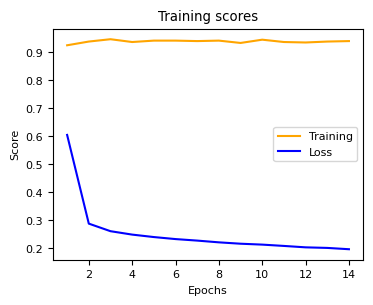

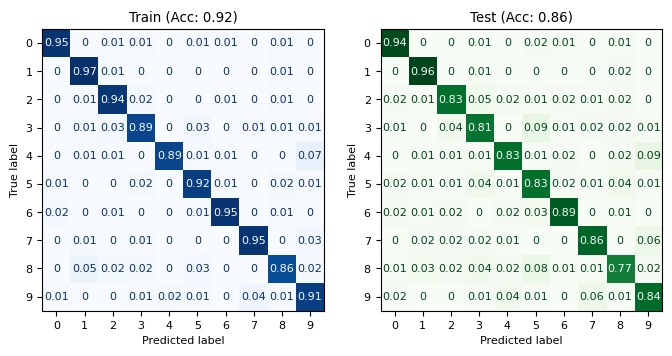

In [139]:
# Plots
plot_train_test_error(mlp_gs.best_estimator_)
plot_confusion_matrix(y_train, pred_train, y_test, pred_test, labels=mlp_gs.best_estimator_.classes_)

By checking the 5 models, the four that I randomly choose and the one that was obtained from searching a reduce parameter space, I can see that the performance between models do not vary much. Except for one model that obtain 81% accuracy, the rest of the models are 86/87% accuracy. Thus, I think that I might be hitting a local minima because I used only 10% of data (extracting random entries from the original data). Perhaps, if I increase the data size, increase the number of dimensions used in LDA, train the MLP for longer or search a larger parameter space, I may increase the test accuracy by a small fraction. 